In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../input/football-match-probability-prediction/train.csv")

for i in df.columns:
    print(i)
display(df['home_team_history_opponent_rating_1'])

id
target
home_team_name
away_team_name
match_date
league_name
league_id
is_cup
home_team_coach_id
away_team_coach_id
home_team_history_match_date_1
home_team_history_match_date_2
home_team_history_match_date_3
home_team_history_match_date_4
home_team_history_match_date_5
home_team_history_match_date_6
home_team_history_match_date_7
home_team_history_match_date_8
home_team_history_match_date_9
home_team_history_match_date_10
home_team_history_is_play_home_1
home_team_history_is_play_home_2
home_team_history_is_play_home_3
home_team_history_is_play_home_4
home_team_history_is_play_home_5
home_team_history_is_play_home_6
home_team_history_is_play_home_7
home_team_history_is_play_home_8
home_team_history_is_play_home_9
home_team_history_is_play_home_10
home_team_history_is_cup_1
home_team_history_is_cup_2
home_team_history_is_cup_3
home_team_history_is_cup_4
home_team_history_is_cup_5
home_team_history_is_cup_6
home_team_history_is_cup_7
home_team_history_is_cup_8
home_team_history_is_cup

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0         5.199840
1         3.671610
2         6.825194
3         5.998800
4         5.535514
            ...   
110933    4.085210
110934    7.571322
110935    3.981619
110936    5.382177
110937    5.496961
Name: home_team_history_opponent_rating_1, Length: 110938, dtype: float64

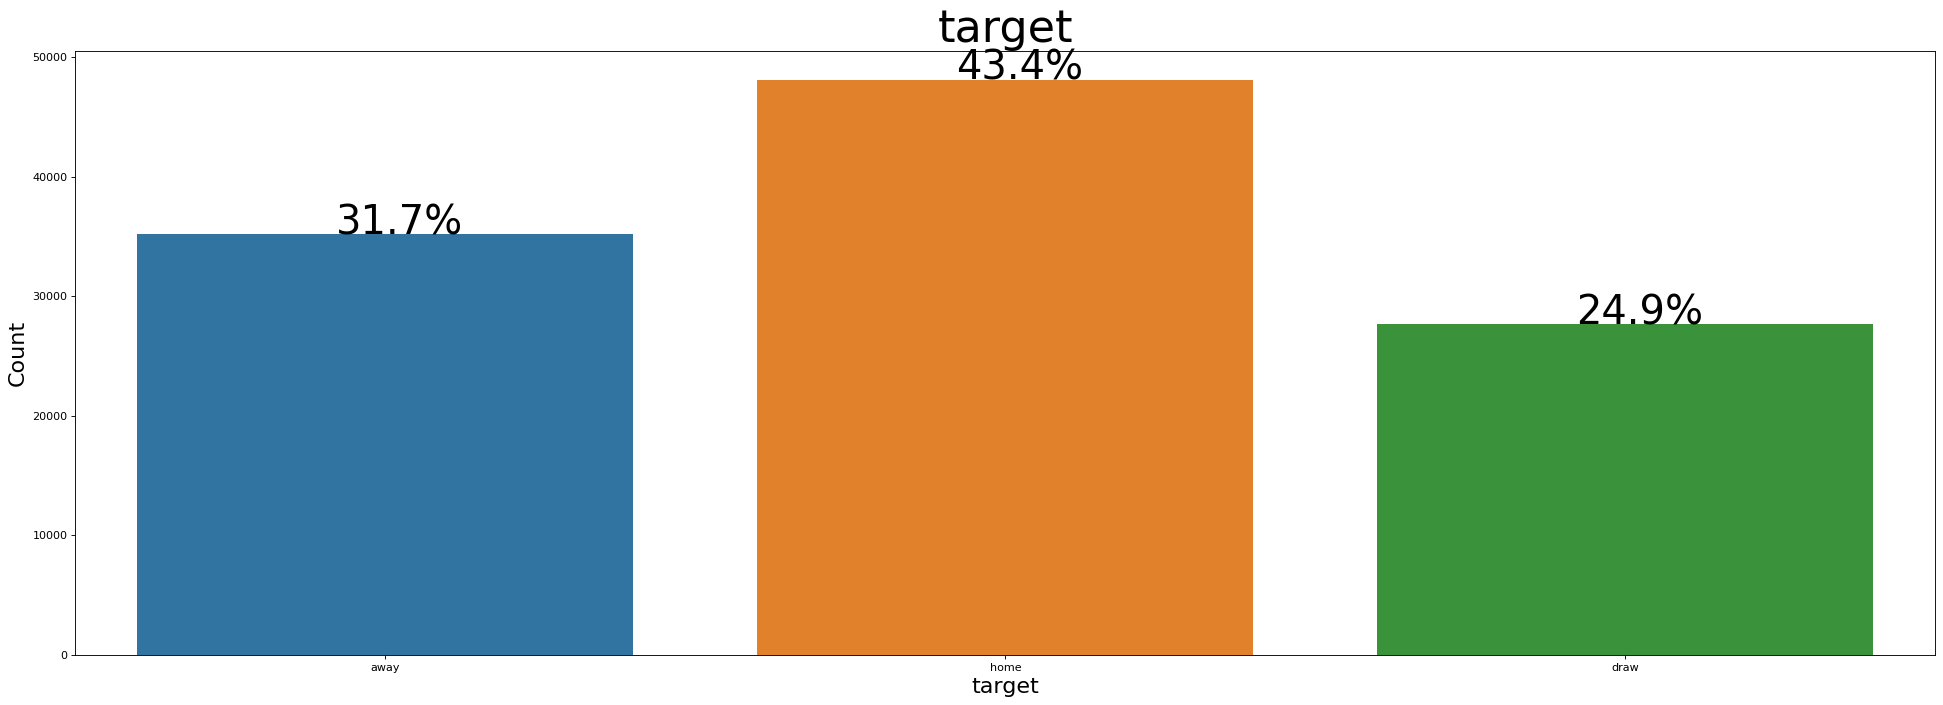

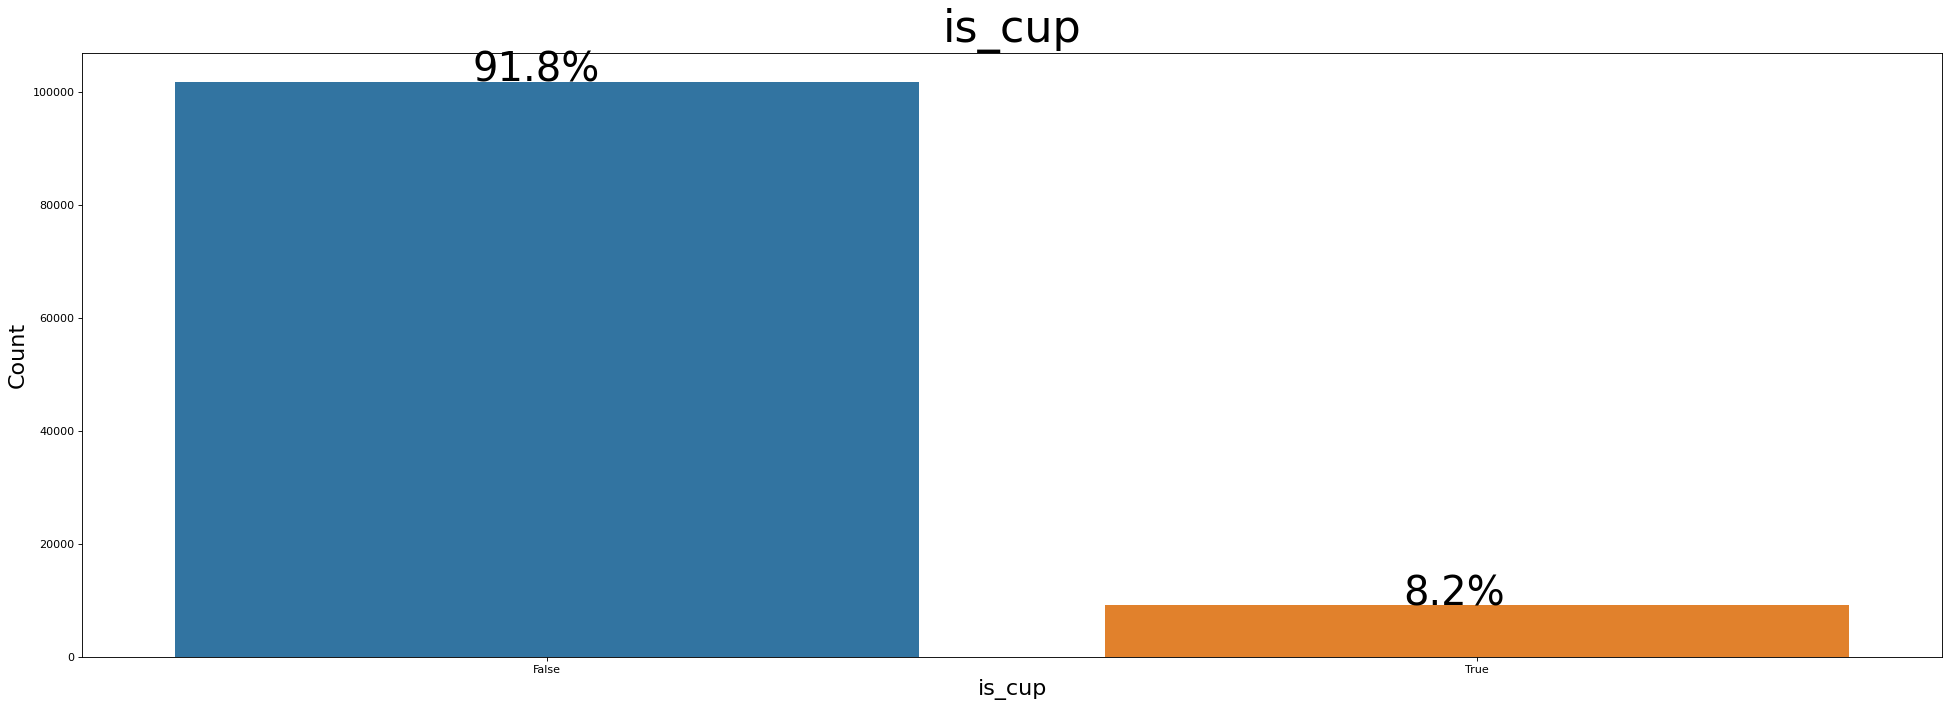

In [2]:
import seaborn as sns
from matplotlib.pyplot import figure


def without_hue(ax, feature,shift=0.08):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - shift
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 36)


features = ['target','is_cup']
sns.color_palette("crest", as_cmap=True)

for col in features:
    figure(figsize=(30, 10), dpi=80)
    ax = sns.countplot(x = df[col])
    plt.title(col, fontsize=40)
    ax.set_xlabel(col, fontsize=20)
    ax.set_ylabel('Count',fontsize=20)
    without_hue(ax,df[col])
    plt.show()

    


target - The target is characterized as the outcome of a match. 'Home' means that the home team won, 'Away' means that the away team won and 'Draw' means that the game resulted in a draw. The data is fairly balanced with 'Home' making up 41% of the targets. This does make sense as the home team is generally seen as having an advantage due to familiarity with the pitch and support from fans during the game.

is_cup - The vast majority of games are not cup games. One idea could be to create a seperate model for cup games as the patterns between cup and league game may differ, especially for cup games that play with the home advantage rules.

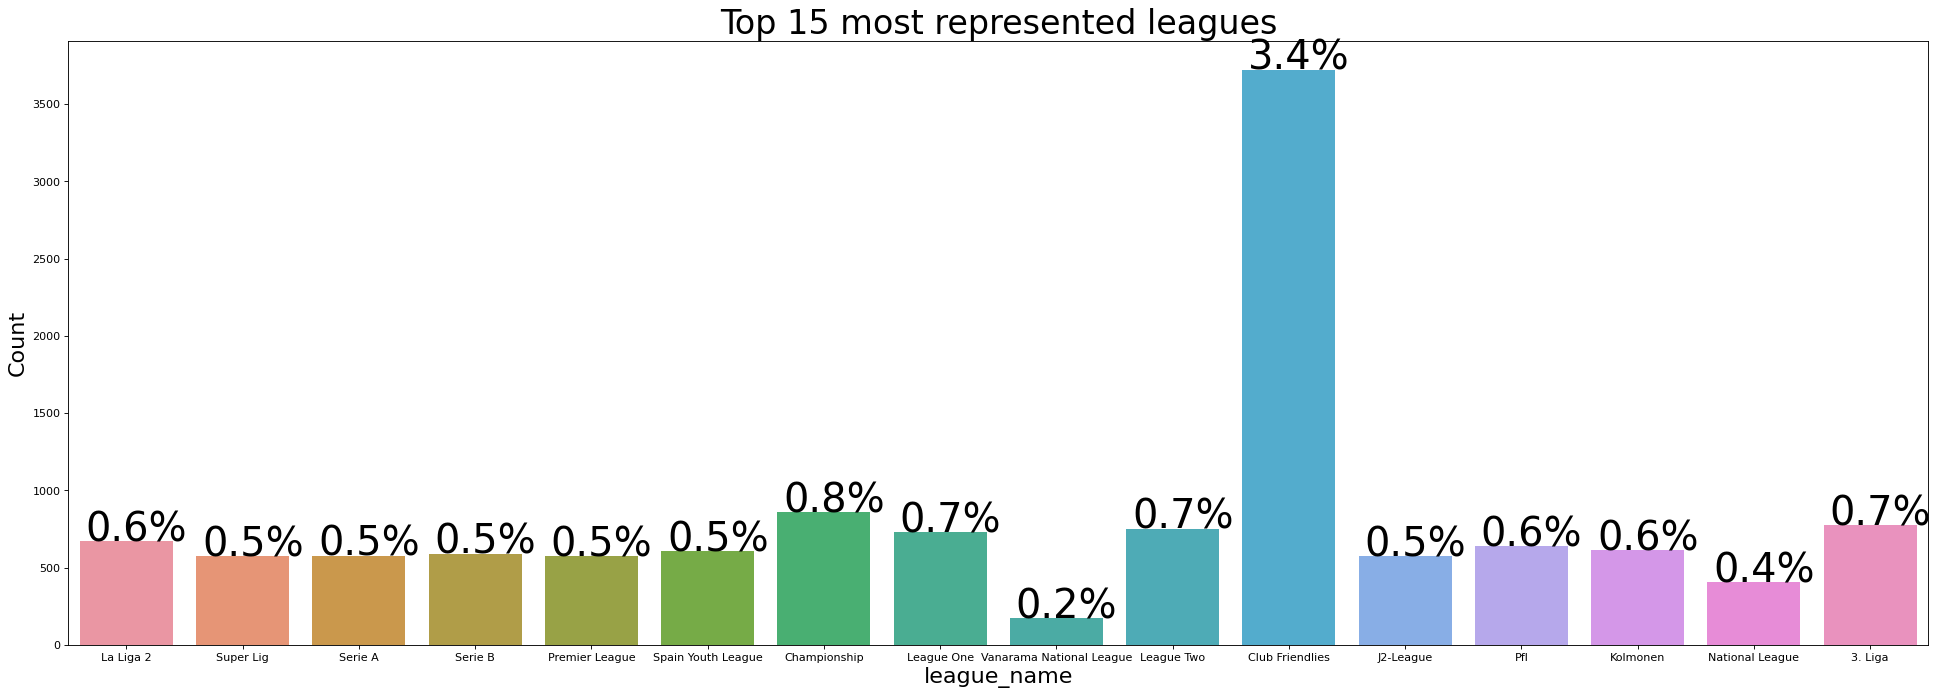

In [3]:
figure(figsize=(30, 10), dpi=80)
n = 15
sns.color_palette("crest", as_cmap=True)

col = 'league_name'
leagues = df['league_id'].value_counts()[:n].index.tolist()
ax = sns.countplot(x = df[df['league_id'].isin(leagues)][col])
plt.title("Top 15 most represented leagues",fontsize=30)
ax.set_xlabel(col, fontsize=20)
ax.set_ylabel('Count',fontsize=20)
without_hue(ax,df['league_id'],shift=0.35)
plt.show()

The distribution of leagues is fairly even with the small exception of "Club Friendlies". One idea could be to filter out all club friendlies since many teams don't field strong XIs for such games. Note that the plot only displays the top 15 represented leagues which only make up a small part of the data.

Text(0, 0.5, 'Amount of games')

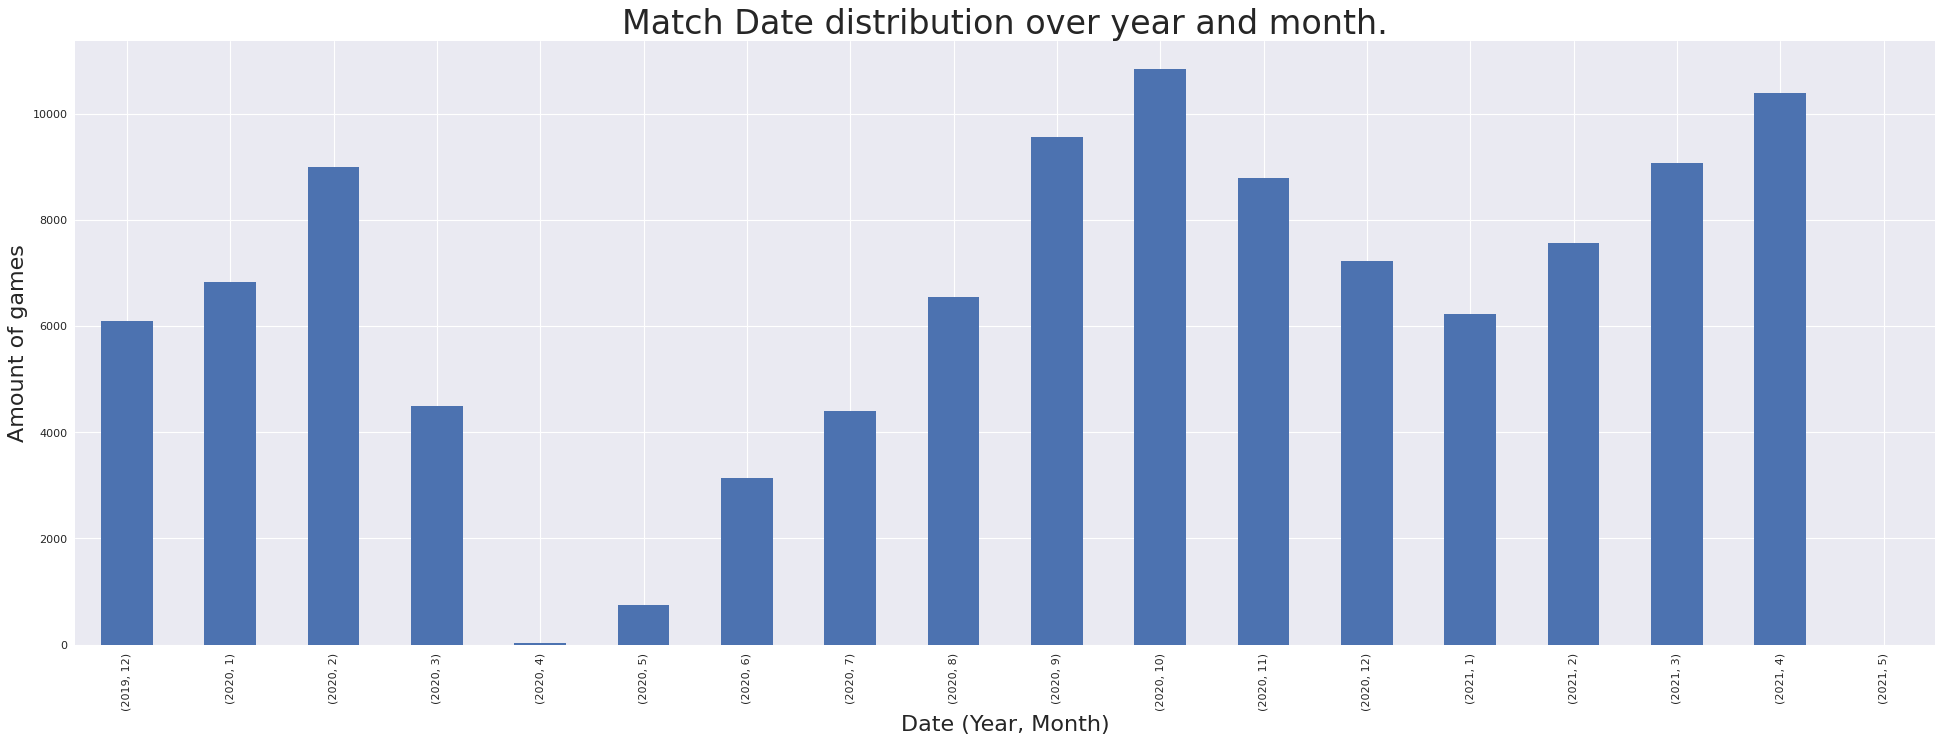

In [4]:
from matplotlib import style

df['date'] = pd.to_datetime(df['match_date'], errors='coerce')

figure(figsize=(30, 10), dpi=80)
style.use(style='seaborn')
ax = df.groupby([df["date"].dt.year, df["date"].dt.month])['date'].count().plot(kind="bar", x='Match Date', y='Count')
ax.set_title("Match Date distribution over year and month.",fontsize=30)
ax.set_xlabel("Date (Year, Month)",fontsize=20)
ax.set_ylabel("Amount of games",fontsize=20)

All games were played during the 2019/20 and 2020/21 seasons. This might cause an issue since many games might have been played without fans due to COVID19, which football fans know is a big disadvantage for the home teams. The advantage of having lots of data for only recent seasons is that the football that was played during this time should be fairly similar to the football that is played today in terms of tactics and playstyles.

Text(0, 0.5, 'Amount of games')

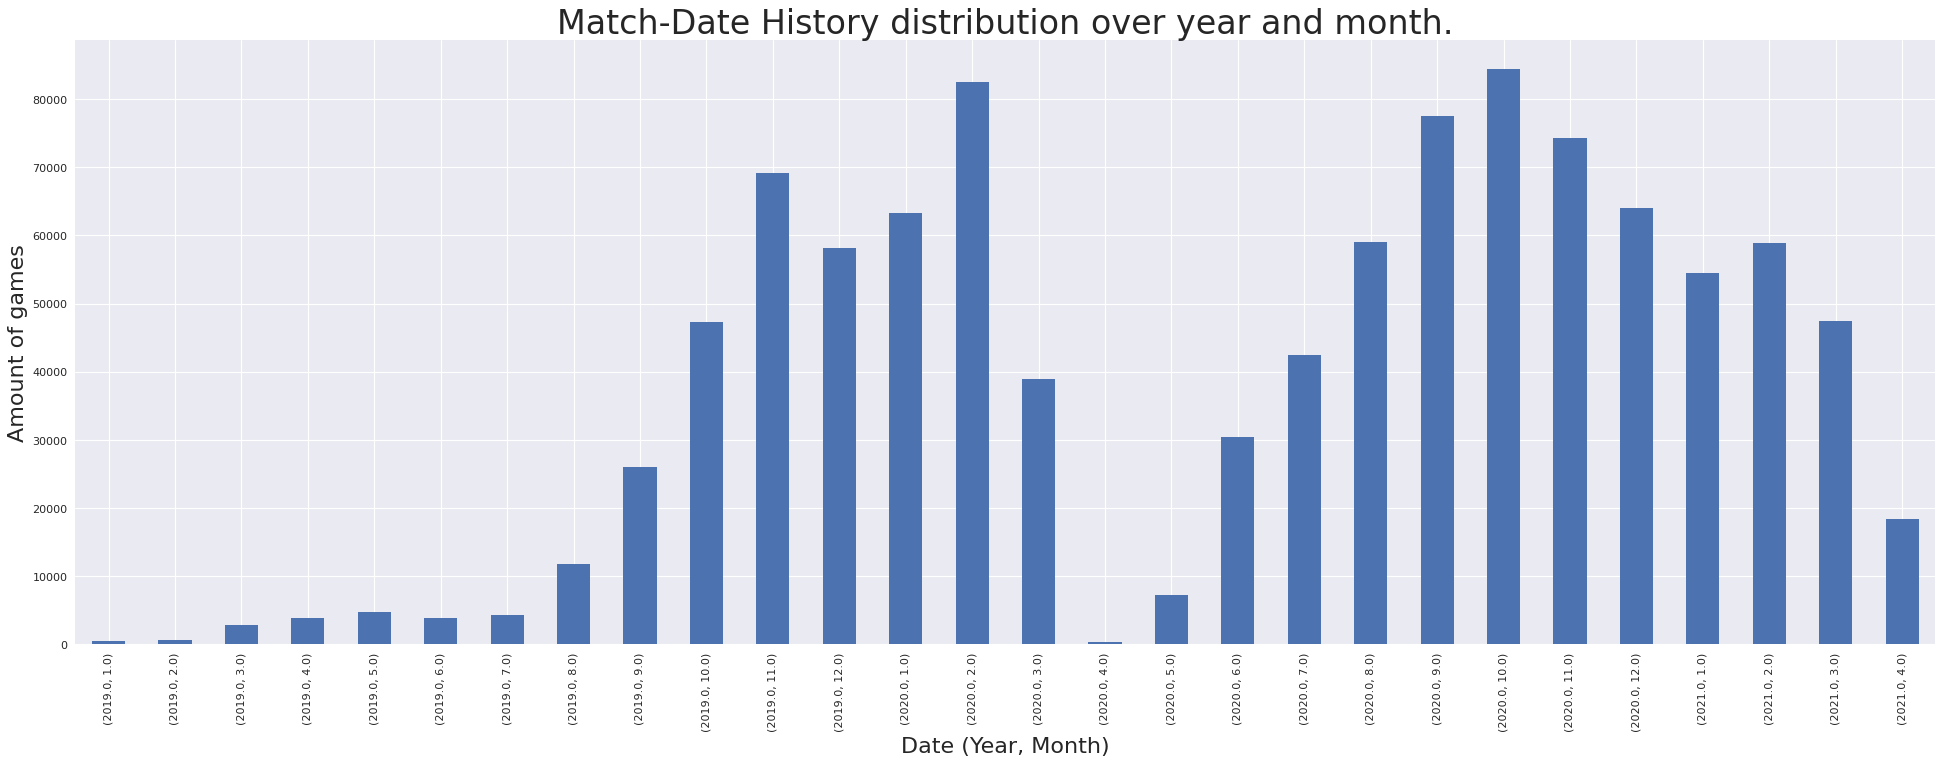

In [5]:
s = 'away_team_history_match_date'
s = 'home_team_history_match_date_'
s_id = 'away_team_history_league_id'
s_id = 'home_team_history_league_id'

column_names = ["date"]
new_df = pd.DataFrame(columns = column_names)

history_df = df.loc[:, df.columns.str.contains(s)| (df.columns == 'id')]
history_df = pd.wide_to_long(history_df, stubnames=s, i="id",j='i')

history_df['date'] = pd.to_datetime(history_df['home_team_history_match_date_'], errors='coerce')

figure(figsize=(30, 10), dpi=80)
style.use(style='seaborn')
ax = history_df.groupby([history_df["date"].dt.year, history_df["date"].dt.month])['date'].count().plot(kind="bar", x='Match Date', y='Count')
ax.set_title("Match-Date History distribution over year and month.",fontsize=30)
ax.set_xlabel("Date (Year, Month)",fontsize=20)
ax.set_ylabel("Amount of games",fontsize=20)

The game history naturally spans a bit further back than the match-date feature.